# 1. Понимание бизнеса#

## 1.1 Цель предсказать оценку качества вина ##

## 1.2 Описание ##
Данные содержат в себе информацию по физико-химическим характеристикам и субъектиной оценке качества Португальского вина "Vinho Verde". Присутствуют красные и белые вина. 
Требуется предстказать оценку качества вина по характеристикам.
ссылка на Kaggle: https://www.kaggle.com/rajyellow46/wine-quality 

# 2. Интерпретация данных#

## 2.1 Импорт библиотек:##

In [412]:
#ignore warnings:
import warnings
warnings.filterwarnings('ignore')

#process data and matricies:
import pandas as pd
import numpy as np
from scipy import stats

#visualization:
import pylab
import matplotlib.pyplot as plt
import seaborn as sns
from jupyterthemes import jtplot
import matplotlib.font_manager
%matplotlib inline
jtplot.style()

#modelling algorithms:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

#scalling and dividing data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

#Evaluation models:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc, roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score

#estimaltion of inliers and outliers
from pyod.models.abod import ABOD
from pyod.models.knn import KNN
from pyod.models.copod import COPOD

## 2.2 Вспомогательные функции:##

In [399]:
def plot_var_importance (X, y):
    tree = DecisionTreeClassifier(random_state= 42)
    tree.fit(X, y)
    plot_model_var_imp(tree, X, y)
    
def plot_model_var_imp(model, X, y):
    imp = pd.DataFrame(
        model.feature_importances_,
        columns = ['Importance'],
        index = X.columns
    )
    imp = imp.sort_values(['Importance'], ascending = True )
    imp[ : 10].plot(kind = 'barh')
    print(model.score(X, y))
    
def detect_outliers(outlier_fraction, classifiers, dataset, para1, para2):

    for i, (clf_name,clf) in enumerate(classifiers.items()) :
        # fit the dataset to the model
        clf.fit(dataset[[para1, para2]])

        # predict raw anomaly score
        scores_pred = clf.decision_function(dataset[[para1, para2]])*-1

        # prediction of a datapoint category outlier or inlier
        y_pred = clf.predict(dataset[[para1, para2]])
        
        X1 = dataset[[para1, para2]].reset_index()
        X1['outlier_flag'] = pd.DataFrame(y_pred)

        return (X1, y_pred)

## 2.3 Загрузка данных

In [2]:
data = pd.read_csv('winequalityN.csv')

In [218]:
print('Размерность данных: ', 'строк - ', data.shape[0], ', столбцов - ',  data.shape[1])

Размерность данных:  строк -  6497 , столбцов -  13


## 2.4 Статистика и визуализации

In [216]:
data.head(3)

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6


**Описание переменных (физико-химические характеристики):**  
1 - fixed acidity (постоянная кислотность)  
2 - volatile acidity (изменющаяся кислотность)  
3 - citric acid (лимонная кислота)  
4 - residual sugar (остаточный сахар)  
5 - chlorides (хлориды)  
6 - free sulfur dioxide (свободные диоксиды серы)  
7 - total sulfur dioxide (общие диоксиды серы)  
8 - density (плотность)  
9 - pH (водородный поазатель)  
10 - sulphates (сульфаты)  
11 - alcohol (алкоголь)  
  
**Целевая переменная:**  
12 - quality (качество - измеряется в баллах 0-10)

### 2.4.1 Ключевая информация о переменных:

числовая переменная - это целое или действительное число и обычно относится к непрерывным переменным. Категориальная преременная дискретна, то есть принимает несколько фиксированных значений и может быть как тектовой, так и числовой (обычно целое число).

посмотрим на типы и количество значений признаков, чтобы выделить из них категориальные и непрерывные, а также пропуски в данных

In [226]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed acidity         6487 non-null   float64
 2   volatile acidity      6489 non-null   float64
 3   citric acid           6494 non-null   float64
 4   residual sugar        6495 non-null   float64
 5   chlorides             6495 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6488 non-null   float64
 10  sulphates             6493 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


к категориальным переменным относятся следующие переменные и целевая переменная quality:

In [245]:
#признаки не числовым типом (категориальные)
feat_cat = [col for col in list(data.columns) if data[col].dtype == 'O']
feat_cat 

['type']

к числовым или непрерывным переменным относятся следующие переменные:

In [249]:
#признаки числовым типом
feat_num = [col for col in list(data.columns) if data[col].dtype != 'O']
feat_num.remove('quality')
feat_num

['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol']

Рассмотрим статистические характеристики признаков датасета:

In [225]:
data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6487.000000,6489.000000,6494.000000,6495.000000,6495.000000,6497.000000,6497.000000,6497.000000,6488.000000,6493.000000,6497.000000,6497.000000
mean,7.216579,0.339691,0.318722,5.444326,0.056042,30.525319,115.744574,0.994697,3.218395,0.531215,10.491801,5.818378
std,1.296750,0.164649,0.145265,4.758125,0.035036,17.749400,56.521855,0.002999,0.160748,0.148814,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


значение count для признаков отличается друг от друга, что означает, что присутствуют пропуски. 

### 2.4.2 Тепловая карта корреляции показывает взаимное влияние или зависиомсть признаков друг от друга, а также влияние на целевую переменную

(12.0, 0.0)

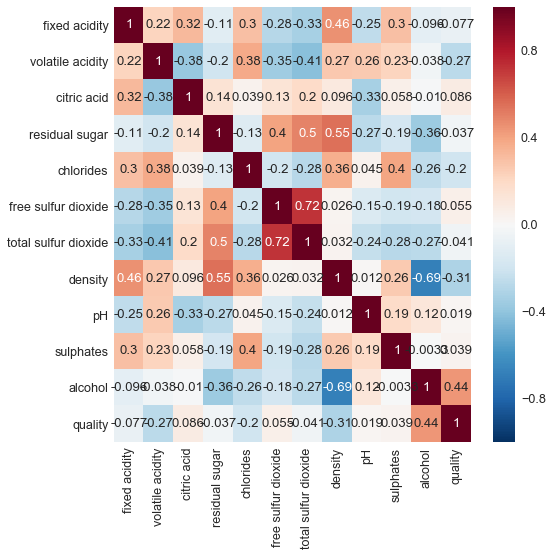

In [228]:
plt.figure(figsize=(8, 8))
ax = sns.heatmap(data[feat_num].corr(), cmap=sns.color_palette("RdBu_r", 1000), vmin=-1, center=0, annot=True)
i, k = ax.get_ylim()
ax.set_ylim(i+0.5, k-0.5)

Наибольшим образом на целевую переменную влияет больше всего Alcohol (0.44), но нельзя сказать, что это сильная связь, так как занчительно меньше 1.  
Так же можно отметить:  
 - небольшую обратную связь между признаками density и alcohol (корреляция -0.69)
 - небольшую прямую связь между признаками total sulfur dioxide и free sulfur dioxide (корреляция 0.72), что вполне логично, так как одно является частью другого.
 - малозаметную прямую связь между density и residual sugar
Так как кореляции низкие, мы не будем удаляь на этапе feature engineering ниакие признаки

### 2.4.3 посмотрим на распределние переменных: в большинстве своем это близкое к экспоненциальному или номальному распрделениям.

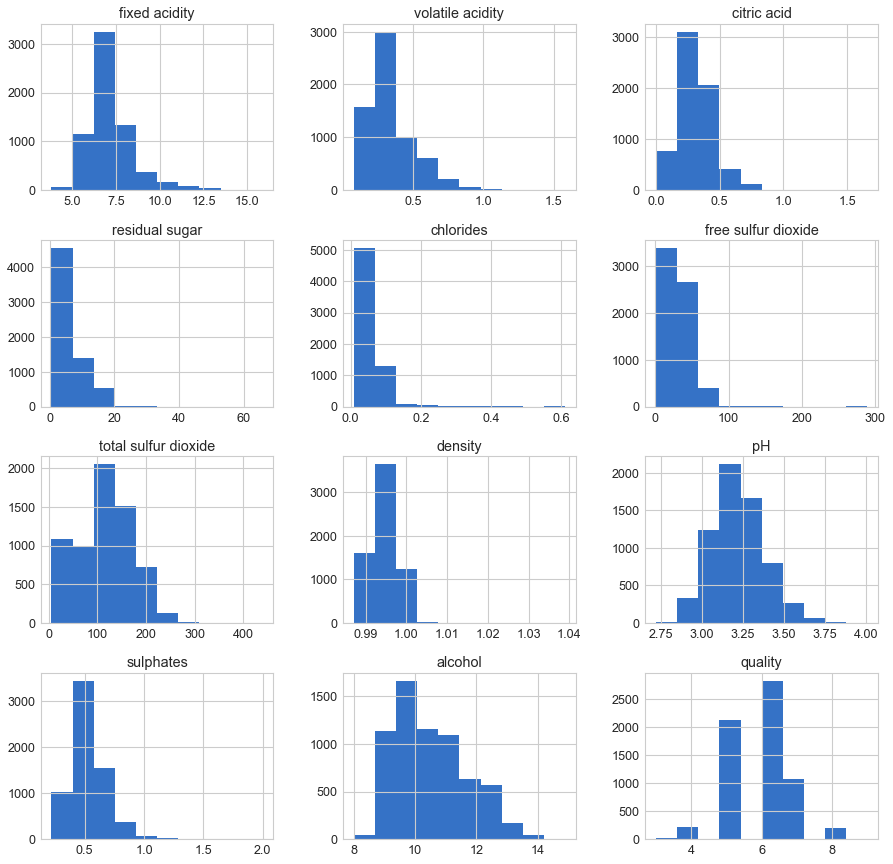

In [231]:
data[feat_num].hist(figsize = (15,15))
plt.show()

# 3. Подготовка данных

## 3.1 Преобразуем категориальные переменные в числовые

Переменная type является категориальной переменной, поэтому с помощью one hot enconding преобразуем ее в чисовую

In [260]:
X = pd.get_dummies(data, columns=feat_cat)
#add new-build numerical features to set of continuios features list
feat_num.append('type_red')
feat_num.append('type_white')

In [261]:
X.head(2)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type_red,type_white
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.001,3.0,0.45,8.8,6,0,1
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.994,3.3,0.49,9.5,6,0,1


## 3.2 Заполняем пустые значения в переменных

список признаков, содержащих  нулевые значения:

In [263]:
nullColList = X.isnull().max()
colNull = list(nullColList[nullColList == True].index)
feat_num_null = [col for col in colNull if X[col].dtype != 'O']
feat_num_null

['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'pH',
 'sulphates']

все эти непрерывные признаки можно заполнить медианным значением, так как не все из них имеют нормальное распределение

In [264]:
for null_feat in feat_num_null:
    X[null_feat] = X[null_feat].fillna(X[null_feat].median())

проверяем результат заполнения и видимо что все значения count для всех признаков одинаковы и равны количеству строк датасета 

In [265]:
X.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type_red,type_white
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.216246,0.339630,0.318718,5.443574,0.056039,30.525319,115.744574,0.994697,3.218384,0.531202,10.491801,5.818378,0.246114,0.753886
std,1.295779,0.164557,0.145231,4.757585,0.035031,17.749400,56.521855,0.002999,0.160637,0.148769,1.192712,0.873255,0.430779,0.430779
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000,0.000000,0.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000,0.000000,1.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000,0.000000,1.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000,0.000000,1.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000,1.000000,1.000000


## 3.3 Feature engineering - работа с признаками

### 3.3.1 Анализ выбросов признаков

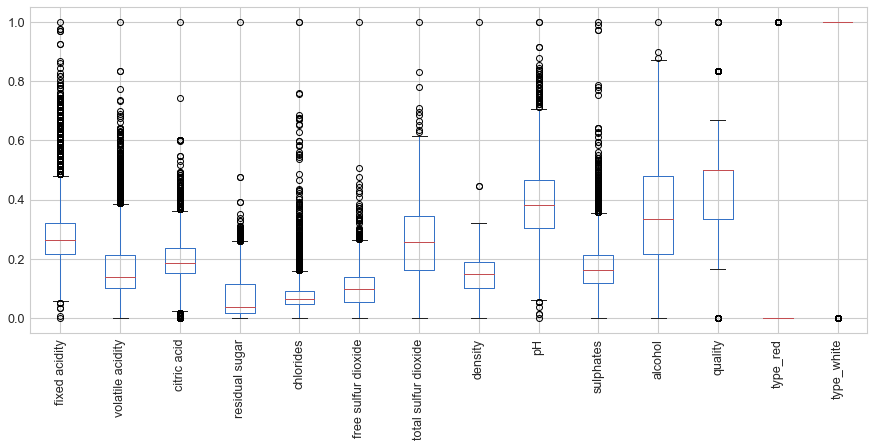

In [329]:
from sklearn.preprocessing import MinMaxScaler
cols_name = X.columns 
mm_scaler = MinMaxScaler()
mm_X = mm_scaler.fit_transform(X)
bp = pd.DataFrame(mm_X, columns = cols_name )
bp.boxplot(figsize = (15,6), rot = 90)

видим достаточно большое количество выбросов у всех признаков. Визуализируем например 'total sulfur dioxide', 'free sulfur dioxide', 'density', 'alcohol', где наблюдается наибольшее количество выбросов.

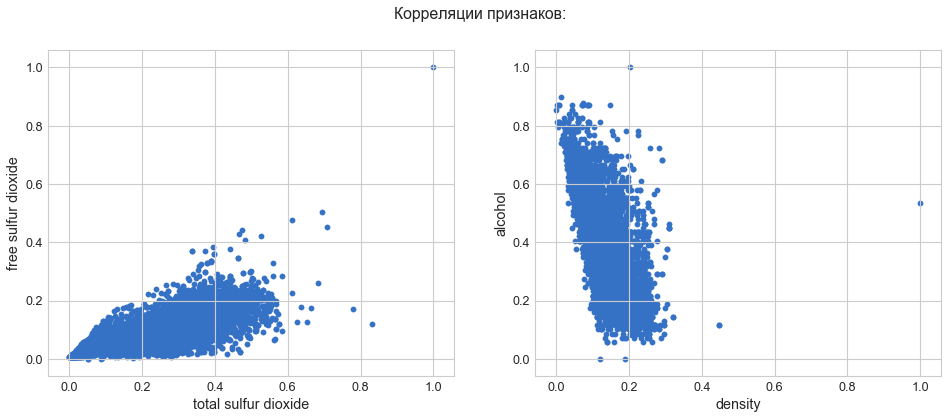

In [285]:
plt.figure(figsize=(16, 6))
plt.suptitle('Корреляции признаков:')
pylab.subplot(1,2,1)
pylab.scatter(bp['total sulfur dioxide'], bp['free sulfur dioxide'])
pylab.xlabel('total sulfur dioxide')
pylab.ylabel('free sulfur dioxide')
pylab.subplot(1,2,2)
pylab.scatter(bp['density'], bp['alcohol'])
pylab.xlabel('density')
pylab.ylabel('alcohol')
plt.show()

Очевидно, что выбросы присутствуют. Применим также методы машинного обучения для выявления выбросов:

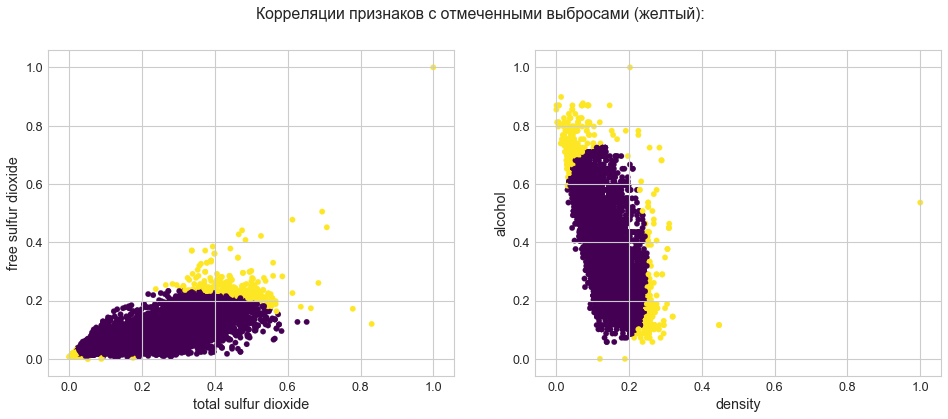

In [301]:
#процент выбросов
outlier_fraction = 0.08

classifiers = {
     'COPOD' : COPOD(contamination=outlier_fraction)
     #'Angle-based Outlier Detector (ABOD)'   : ABOD(contamination=outlier_fraction),
     #'K Nearest Neighbors (KNN)' :  KNN(contamination=outlier_fraction)
}

d1, p1 = detect_outliers(outlier_fraction, classifiers, bp, 'total sulfur dioxide', 'free sulfur dioxide')
d2, p2 = detect_outliers(outlier_fraction, classifiers, bp, 'density', 'alcohol')

plt.figure(figsize=(16, 6))
plt.suptitle('Корреляции признаков с отмеченными выбросами (желтый):')
pylab.subplot(1,2,1)
pylab.scatter(d1['total sulfur dioxide'], d1['free sulfur dioxide'], c = p1) 
pylab.xlabel('total sulfur dioxide')
pylab.ylabel('free sulfur dioxide')
pylab.subplot(1,2,2)
pylab.scatter(d2['density'], d2['alcohol'], c = p2)
pylab.xlabel('density')
pylab.ylabel('alcohol')
plt.show()

Удалим данные за до 1 и после 99 персентиля и сверимся насколько выбросов стало меньше по боксплоту и скэттерплоту:

In [343]:
low = .01
high = .99
df = pd.DataFrame()
quant = bp[bp.columns[:11]].quantile([low,high])
df = bp[bp.columns[:11]].apply(lambda x: x[(x > quant.loc[low, x.name]) &(x < quant.loc[high, x.name])], axis=0)

quant

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0.01,0.107438,0.026667,0.000000,0.004601,0.019934,0.010417,0.011521,0.034895,0.131783,0.044944,0.101449
0.99,0.677686,0.533333,0.445783,0.269939,0.294286,0.263889,0.534562,0.260073,0.713178,0.432584,0.782609


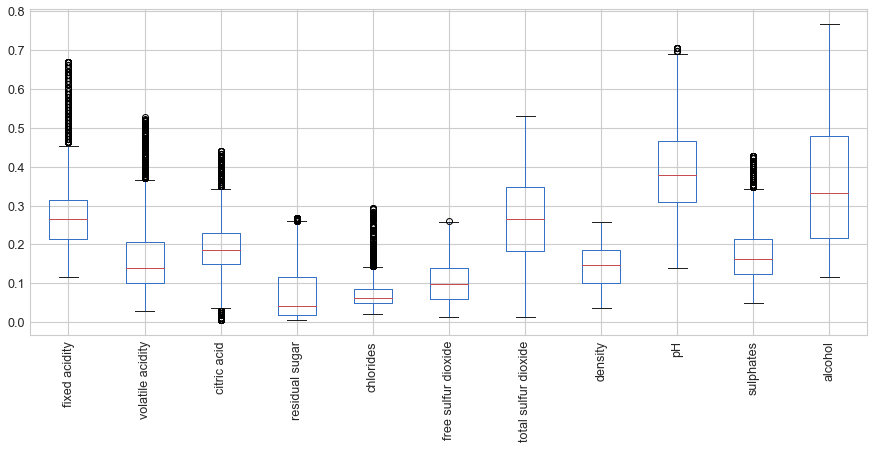

In [347]:
df.dropna().boxplot(figsize = (15,6), rot = 90)

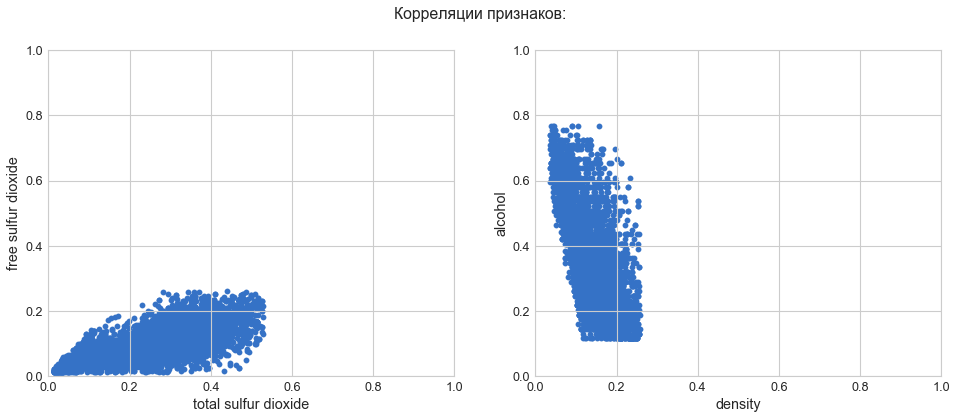

In [350]:
plt.figure(figsize=(16, 6))
plt.suptitle('Корреляции признаков:')
pylab.subplot(1,2,1)
pylab.xlim(0,1)
pylab.ylim(0,1)
pylab.scatter(df.dropna()['total sulfur dioxide'], df.dropna()['free sulfur dioxide'])
pylab.xlabel('total sulfur dioxide')
pylab.ylabel('free sulfur dioxide')
pylab.subplot(1,2,2)
pylab.xlim(0,1)
pylab.ylim(0,1)
pylab.scatter(df.dropna()['density'], df.dropna()['alcohol'])
pylab.xlabel('density')
pylab.ylabel('alcohol')
plt.show()

при удалении строк с выбросами до 1% квантиля и после 99% квантиля, выбросов стало гораздо меньше: некоторые признаки вообще избавились от выбросов, а оставшиеся на диаграммаз рассеивания не содержат очевидных выбросов.

In [351]:
df['quality'] = bp['quality']
df['type_red'] = bp['type_red']
df['type_white'] = bp['type_white']

In [353]:
df = df.dropna()

In [363]:
df.head(3)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type_red,type_white
1,0.206612,0.146667,0.204819,0.015337,0.066445,0.045139,0.290323,0.132832,0.449612,0.151685,0.217391,0.5,0.0,1.0
2,0.355372,0.133333,0.240964,0.096626,0.068106,0.100694,0.209677,0.154039,0.418605,0.123596,0.304348,0.5,0.0,1.0
3,0.280992,0.100000,0.192771,0.121166,0.081395,0.159722,0.414747,0.163678,0.364341,0.101124,0.275362,0.5,0.0,1.0


In [356]:
Xy = mm_scaler.inverse_transform(df)

In [365]:
df_adopted = pd.DataFrame(Xy, columns = bp.columns)

In [366]:
df_adopted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5124 entries, 0 to 5123
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         5124 non-null   float64
 1   volatile acidity      5124 non-null   float64
 2   citric acid           5124 non-null   float64
 3   residual sugar        5124 non-null   float64
 4   chlorides             5124 non-null   float64
 5   free sulfur dioxide   5124 non-null   float64
 6   total sulfur dioxide  5124 non-null   float64
 7   density               5124 non-null   float64
 8   pH                    5124 non-null   float64
 9   sulphates             5124 non-null   float64
 10  alcohol               5124 non-null   float64
 11  quality               5124 non-null   float64
 12  type_red              5124 non-null   float64
 13  type_white            5124 non-null   float64
dtypes: float64(14)
memory usage: 560.6 KB


In [367]:
df_adopted.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type_red,type_white
count,5124.000000,5124.000000,5124.000000,5124.000000,5124.000000,5124.000000,5124.000000,5124.000000,5124.000000,5124.000000,5124.000000,5124.000000,5124.000000,5124.000000
mean,7.169331,0.326800,0.316708,5.433724,0.053133,30.724824,118.920570,0.994608,3.217408,0.525991,10.469993,5.833528,0.218384,0.781616
std,1.096969,0.143999,0.122264,4.491426,0.022888,15.736924,52.547337,0.002727,0.143539,0.124572,1.111621,0.846045,0.413190,0.413190
min,5.200000,0.125000,0.010000,0.950000,0.022000,5.000000,12.000000,0.988940,2.900000,0.310000,8.800000,3.000000,0.000000,0.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,18.000000,86.000000,0.992387,3.120000,0.440000,9.500000,5.000000,0.000000,1.000000
50%,7.000000,0.290000,0.310000,3.300000,0.047000,29.000000,121.000000,0.994800,3.210000,0.510000,10.300000,6.000000,0.000000,1.000000
75%,7.600000,0.390000,0.380000,8.100000,0.061000,41.000000,157.000000,0.996800,3.320000,0.600000,11.300000,6.000000,0.000000,1.000000
max,11.900000,0.870000,0.730000,18.150000,0.186000,76.000000,236.000000,1.000500,3.630000,0.980000,13.300000,9.000000,1.000000,1.000000


### 3.3.2 Класс не сбалансированы

In [377]:
df_adopted['quality'].value_counts()

6.0    2290
5.0    1693
7.0     841
8.0     149
4.0     136
3.0      12
9.0       3
Name: quality, dtype: int64

слишком большой разброс и не очень большой датасет, поэтому балансировка не имеет смысла

## 3.4 Сборка финальных датасетов для моделирования

### 3.4.1 Выбор переменных 

выбираем все признаки, так как корреляция межу ними слабая.

### 3.4.2 Создание датасетов

Отделяем данные для обучения и проверки:

In [548]:
valid_rate = 0.9
train_end_pos = round(df_adopted.shape[0] * valid_rate)
if valid_rate == 1: 
    train_end_pos = df_adopted.shape[0]
    print(1)
else: 
    train_end_pos = round(df_adopted.shape[0] * valid_rate)
    
train_valid_X = df_adopted[0:train_end_pos].drop('quality', axis = 1)
test_X =        df_adopted[train_end_pos:].drop('quality', axis = 1)
train_valid_y = df_adopted[0:train_end_pos].quality.astype(int)
test_y = df_adopted[train_end_pos:].quality.astype(int)

train_X, valid_X, train_y, valid_y = train_test_split(train_valid_X, train_valid_y, train_size = 0.8)

print('Размер полного датасета:', df_adopted.shape)
print('Размер тренировочного датасета', train_X.shape)
print('Размер валидационного датасета', valid_X.shape)
print('Размер тестового датасета', test_X.shape)

Размер полного датасета: (5124, 14)
Размер тренировочного датасета (3689, 13)
Размер валидационного датасета (923, 13)
Размер тестового датасета (512, 13)


### 3.4.3 Важность признаков

Оценим важность признаков, чтобы сделать прогноз

1.0


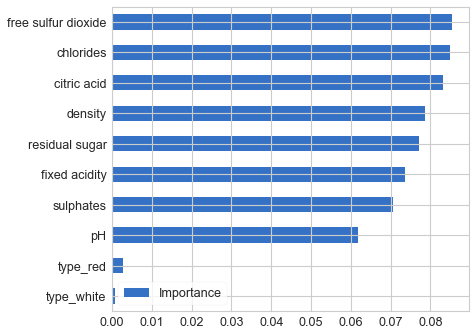

In [534]:
plot_var_importance(train_X, train_y)

нельзя сказать, что какие-то признаки значительно сильнее выделяются по сравнению с другими, тем не менее видим, что не значительными являюстся признаки type_white, type_red, то есть не вжано какое вино белое или красное

# 4 Моделирование

Выбираем наиболее подходящие модели и тестируем результат на тестовой вборке

In [404]:
clf1 = KNeighborsClassifier()
clf2 = RandomForestClassifier()
clf3 = RidgeClassifier()
clf4 = SVC()
clf5 = LogisticRegression()

In [510]:
params1 = {'n_neighbors': range(1,20)}
params2 = {
            'max_depth': range(2, 19, 3),
            'min_samples_leaf': range(2, 19, 3),
            'n_estimators': [5, 10, 15, 20, 50, 70, 90]
            }
params3 = {'alpha': [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.5, 1.0, 5., 10.]}
params4 = {'kernel': ['poly', 'rbf']}
params5 = {}

In [535]:
best_estimators = []
for clf, params_dict in zip([clf1, clf2, clf3, clf4, clf5], [params1, params2, params3, params4, params5]):
    grid = GridSearchCV(clf, params_dict, cv=3, scoring='accuracy')
    grid.fit(train_X, train_y)
    print(clf.__class__.__name__, ':', grid.best_params_,"\t", 'acc:', grid.best_score_)
    best_estimators.append(grid.best_estimator_)

KNeighborsClassifier : {'n_neighbors': 1} 	 acc: 0.6595288654269781
RandomForestClassifier : {'max_depth': 14, 'min_samples_leaf': 2, 'n_estimators': 50} 	 acc: 0.7690448312131616
RidgeClassifier : {'alpha': 5.0} 	 acc: 0.692600457330855
SVC : {'kernel': 'poly'} 	 acc: 0.6194089979955942
LogisticRegression : {} 	 acc: 0.6329635436305542


# 5 Оценка

## 5.1 Модель

Оценим точность модели на основе тестового датасета, где м знаем фактический результат. Набор не использовался для обучения, поэтому он абсолютно ноый для модели 

In [536]:
print('Точность модели К ближайших соседей: ', accuracy_score(valid_y, best_estimators[0].predict(valid_X)))
print('Точность модели случайного леса: ', accuracy_score(valid_y, best_estimators[1].predict(valid_X)))
print('Точность модели Ridge: ', accuracy_score(valid_y, best_estimators[2].predict(valid_X)))
print('Точность модели методом опорных векторов: ', accuracy_score(valid_y, best_estimators[3].predict(valid_X)))
print('Точность модели логистической регрессии: ', accuracy_score(valid_y, best_estimators[4].predict(valid_X)))

Точность модели К ближайших соседей:  0.6706392199349945
Точность модели случайного леса:  0.7573131094257854
Точность модели Ridge:  0.6793066088840737
Точность модели методом опорных векторов:  0.5742145178764897
Точность модели логистической регрессии:  0.6088840736728061


Видим, что на валидационной выборке результаты слегка ниже, чем на обучающей. Самый выскоий результат показывет модель случайного леса при параметрах 'max_depth': 14, 'min_samples_leaf': 2, 'n_estimators': 50.  Поэтому выбираем модель случайного леса. Ее точночть составляет примерно 75%.

# 6. Развертывание

In [550]:
test_X

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type_red,type_white
4612,10.1,0.450,0.23,1.9,0.082,10.0,18.0,0.99774,3.22,0.65,9.3,1.0,0.0
4613,7.2,0.660,0.03,2.3,0.078,16.0,86.0,0.99743,3.53,0.57,9.7,1.0,0.0
4614,7.2,0.630,0.03,2.2,0.080,17.0,88.0,0.99745,3.53,0.58,9.8,1.0,0.0
4615,7.1,0.590,0.01,2.3,0.080,27.0,43.0,0.99550,3.42,0.58,10.7,1.0,0.0
4616,8.3,0.310,0.39,2.4,0.078,17.0,43.0,0.99444,3.31,0.77,12.5,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5119,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,1.0,0.0
5120,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.51,11.2,1.0,0.0
5121,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,1.0,0.0
5122,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,1.0,0.0


In [551]:
test_y_predict = best_estimators[1].predict(test_X)

In [552]:
result = test_X
result['quality'] = test_y
result['predicted quality'] = test_y_predict

In [553]:
result

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type_red,type_white,quality,predicted quality
4612,10.1,0.450,0.23,1.9,0.082,10.0,18.0,0.99774,3.22,0.65,9.3,1.0,0.0,6,5
4613,7.2,0.660,0.03,2.3,0.078,16.0,86.0,0.99743,3.53,0.57,9.7,1.0,0.0,5,5
4614,7.2,0.630,0.03,2.2,0.080,17.0,88.0,0.99745,3.53,0.58,9.8,1.0,0.0,6,5
4615,7.1,0.590,0.01,2.3,0.080,27.0,43.0,0.99550,3.42,0.58,10.7,1.0,0.0,6,6
4616,8.3,0.310,0.39,2.4,0.078,17.0,43.0,0.99444,3.31,0.77,12.5,1.0,0.0,6,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5119,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,1.0,0.0,5,6
5120,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.51,11.2,1.0,0.0,6,6
5121,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,1.0,0.0,6,6
5122,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,1.0,0.0,5,6
